In [ ]:
#|default_exp tmp

# Upscale multiarch

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
import timm

In [ ]:
from miniai.learner import Mean, master_bar, progress_bar

class MetricsCB(Callback):
    def __init__(self, *ms, device=def_device, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()
        self.device = def_device

    def _log(self, d): print(d)
    def before_fit(self, learn): 
        learn.metrics = self
        for cb in learn.cbs: 
            if isinstance(cb, DeviceCB): 
                self.device = cb.device
                
    def before_epoch(self, learn): 
        for o in self.all_metrics.values(): 
            o.reset()
            o.to(self.device)
    
    @torch.no_grad()
    def after_epoch(self, learn):
        log = {k:f'{to_cpu(v.compute()):.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)
    
    @torch.no_grad()
    def after_batch(self, learn):
        x,y,*_ = learn.batch
        for m in self.metrics.values(): m.update(learn.preds, y)
        self.loss.update(learn.loss, weight=len(x))

class ProgressCB(Callback):
    order = MetricsCB.order+1
    def __init__(self, plot=False): 
        self.plot = plot
        self.count = 0
    def before_fit(self, learn):
        learn.epochs = self.mbar = master_bar(learn.epochs)
        self.first = True
        if hasattr(learn, 'metrics'): learn.metrics._log = self._log
        self.dev_losses = []
        self.losses = []

    def _log(self, d):
        if self.first:
            self.mbar.write(list(d), table=True)
            self.first = False
        self.mbar.write(list(d.values()), table=True)
        if self.plot:
            for l in self.dev_losses: self.losses.append(to_cpu(l))
            self.dev_losses=[]
            #print(self.losses[:10])
            self.mbar.update_graph([[fc.L.range(self.losses), self.losses]])
        
    def before_epoch(self, learn): learn.dl = progress_bar(learn.dl, leave=False, parent=self.mbar)
    def after_batch(self, learn):
        #learn.dl.comment = f'{learn.loss:.3f}'
        if self.plot and hasattr(learn, 'metrics') and learn.training:
            self.dev_losses.append(learn.loss.detach())

In [ ]:
timm.list_models('resnet*d')

['resnet18d',
 'resnet26d',
 'resnet34d',
 'resnet50d',
 'resnet101d',
 'resnet152d',
 'resnet200d',
 'resnetaa50d',
 'resnetaa101d',
 'resnetblur50d',
 'resnetblur101d',
 'resnetv2_50d',
 'resnetv2_50x1_bit_distilled',
 'resnetv2_101d',
 'resnetv2_152d']

In [ ]:
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = False 

In [ ]:
from miniai.utils import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

import logging
logging.disable(logging.WARNING)

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8

In [ ]:
p = 0.1
dist = distributions.binomial.Binomial(probs=1-p)
dist.sample((10,))

tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  #(uncomment if needed,but you likely already have it)

#Mish - "Mish: A Self Regularized Non-Monotonic Neural Activation Function"
#https://arxiv.org/abs/1908.08681v1
#implemented for PyTorch / FastAI by lessw2020 
#github: https://github.com/lessw2020/mish

class Mish(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        #inlining this saves 1 second per epoch (V100 GPU) vs having a temp x and then returning x(!)
        return x *( torch.tanh(F.softplus(x)))

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 256
xmean,xstd = 0.29, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

dsd = load_dataset(name)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
tds = cache_dataset_as_dict(dsd.with_transform(transformi))

In [ ]:
set_seed(42)
lr,epochs = 6e-2,5

In [ ]:
def get_model7(act=nn.ReLU, nfs=(16,32,64,128,256,512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [nn.Dropout2d(0.2), nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers).to(def_device)

In [ ]:
# tweaked from rohitgeo's version
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(Mish))
timeit = TimeItCB()
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, timeit]

# #0.0003 from https://github.com/digantamisra98/Mish/issues/37

In [ ]:
def run(model, leaky, seed=42, m=8, xtra=tuple(), epochs=5):
    iw = partial(init_weights, leaky=leaky) if leaky is not None else fc.noop
    set_seed(seed)
    print(f'Init with {iw}')
    model = model.apply(iw)

    lr = 1e-2 *m
    dls = DataLoaders.from_dd(tds, bs*m, num_workers=0)
    tmax = epochs * len(dls.train)
    sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
    xtra = [BatchSchedCB(sched)]+xtra
    
    print ('batchsize', dls.train.batch_size, xtra)
    learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
    if epochs: learn.fit(epochs)
    return learn

## resize images for resnet properly


In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=0)
bx,by = next(iter(dls.train))

In [ ]:
bx.shape

torch.Size([256, 1, 28, 28])

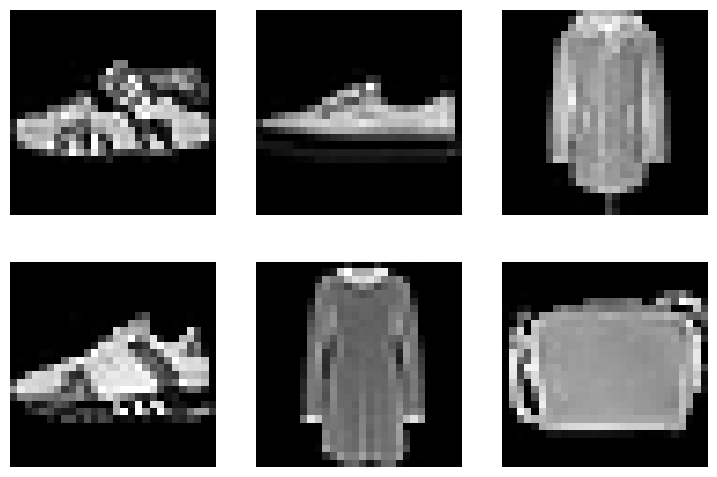

In [ ]:
show_images(bx[:6], imsize=3)

In [ ]:
F.interpolate(bx, scale_factor=8).shape

torch.Size([256, 1, 224, 224])

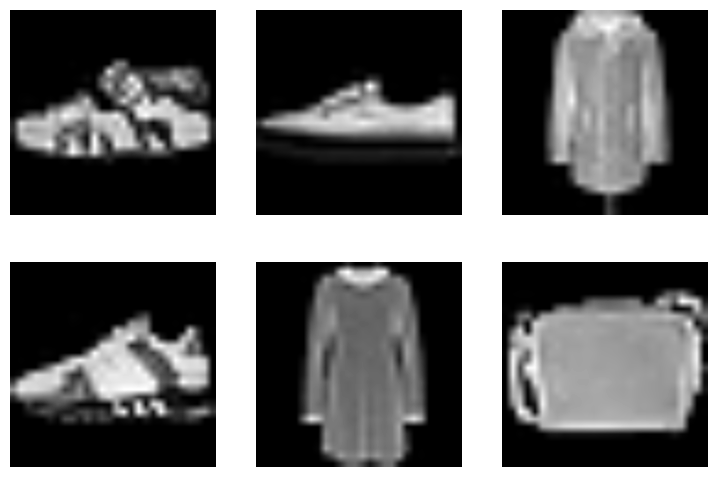

In [ ]:
show_images(F.interpolate(bx[:6], scale_factor=8, mode='bilinear'), imsize=3)

In [ ]:
def upscale_cb(scale, mode='bilinear'): 
    return BatchTransformCB(lambda b: (F.interpolate(b[0], scale_factor=scale, mode=mode),b[1]),
                            on_val=True, on_train=True)

## Architecture Model 

## bs 2048, 2x

Init with functools.partial(<function init_weights>, leaky=0.0003)
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.771,0.689,0,train
0.804,0.838,0,eval
0.898,0.278,1,train
0.833,0.485,1,eval
0.927,0.202,2,train
0.905,0.264,2,eval
0.946,0.146,3,train
0.928,0.195,3,eval
0.964,0.102,4,train
0.937,0.180,4,eval


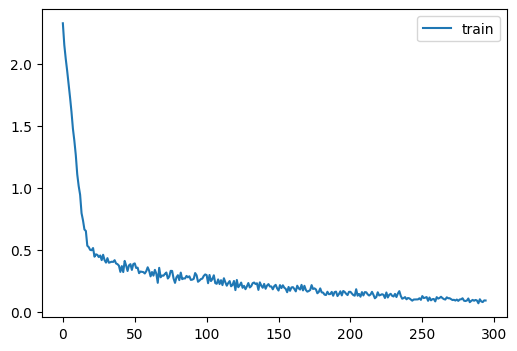

Fit 5 in: 63.18s, setup: 0.00s, 11.33 ± 6.91s per epoch, 0.09 ± 0.95s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.Hardswish), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

Init with <function noop>
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.799,0.577,0,train
0.656,2.511,0,eval
0.895,0.286,1,train
0.876,0.361,1,eval
0.925,0.207,2,train
0.907,0.259,2,eval
0.944,0.152,3,train
0.932,0.193,3,eval
0.961,0.109,4,train
0.939,0.176,4,eval


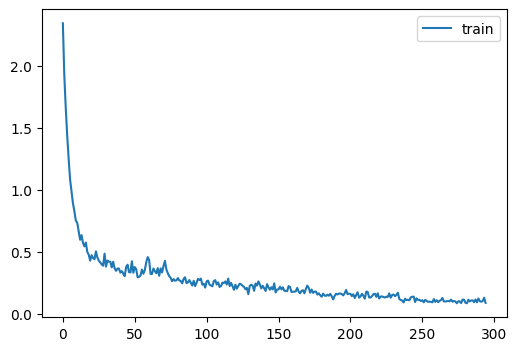

Fit 5 in: 40.50s, setup: 0.00s, 7.70 ± 0.01s per epoch, 0.02 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10),  
            leaky=None, xtra=[upscale_cb(2, 'nearest')], m=4)

Init with functools.partial(<function init_weights>, leaky=0)
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.794,0.598,0,train
0.760,1.000,0,eval
0.897,0.284,1,train
0.852,0.408,1,eval
0.925,0.202,2,train
0.897,0.291,2,eval
0.947,0.146,3,train
0.930,0.195,3,eval
0.964,0.102,4,train
0.938,0.177,4,eval


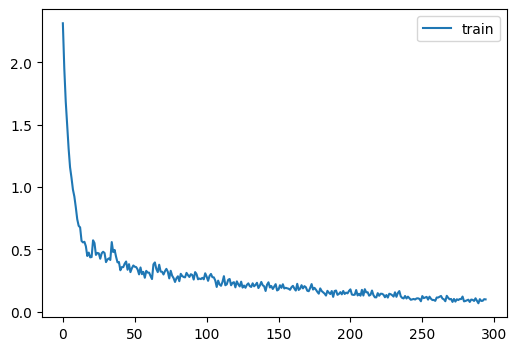

Fit 5 in: 40.71s, setup: 0.00s, 7.74 ± 0.02s per epoch, 0.02 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10),  
            leaky=0, xtra=[upscale_cb(2, 'nearest')], m=4)

Init with functools.partial(<function init_weights>, leaky=0.1)
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.787,0.635,0,train
0.587,2.515,0,eval
0.895,0.291,1,train
0.869,0.368,1,eval
0.923,0.210,2,train
0.910,0.247,2,eval
0.943,0.155,3,train
0.929,0.195,3,eval
0.960,0.110,4,train
0.938,0.178,4,eval


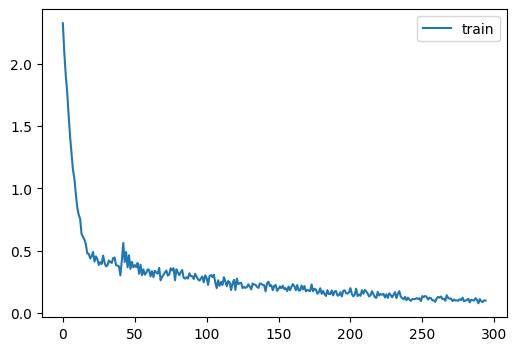

Fit 5 in: 42.01s, setup: 0.00s, 7.97 ± 0.05s per epoch, 0.03 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=lambda inplace:GeneralRelu(leak=0.1, sub=0.4)),  
            leaky=0.1, xtra=[upscale_cb(2, 'nearest')], m=4)

Init with functools.partial(<function init_weights>, leaky=0.1)
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.793,0.604,0,train
0.853,0.500,0,eval
0.896,0.287,1,train
0.870,0.389,1,eval
0.925,0.205,2,train
0.907,0.268,2,eval
0.945,0.149,3,train
0.931,0.188,3,eval
0.961,0.106,4,train
0.938,0.175,4,eval


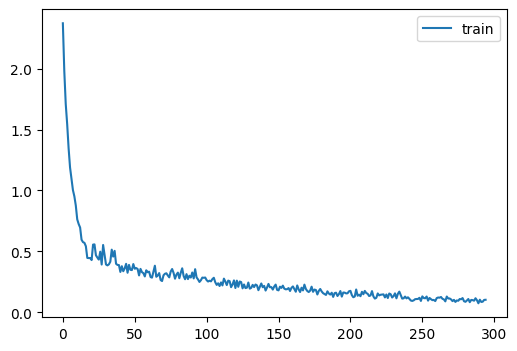

Fit 5 in: 40.89s, setup: 0.00s, 7.78 ± 0.02s per epoch, 0.02 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=partial(nn.LeakyReLU, 0.1)),  
            leaky=0.1, xtra=[upscale_cb(2, 'nearest')], m=4)

Init with functools.partial(<function init_weights>, leaky=0.0003)
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.784,0.652,0,train
0.255,16.350,0,eval
0.899,0.275,1,train
0.854,0.423,1,eval
0.927,0.198,2,train
0.914,0.251,2,eval
0.947,0.145,3,train
0.933,0.191,3,eval
0.964,0.100,4,train
0.938,0.179,4,eval


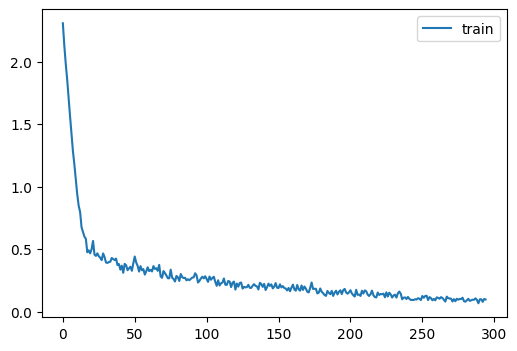

Fit 5 in: 41.85s, setup: 0.00s, 7.97 ± 0.02s per epoch, 0.03 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

Init with functools.partial(<function init_weights>, leaky=0.0003)
batchsize 1024 [<miniai.sgd.BatchSchedCB object>, <miniai.init.BatchTransformCB object>]


accuracy,loss,epoch,train
0.784,0.652,0,train
0.260,14.668,0,eval
0.898,0.276,1,train
0.820,0.534,1,eval
0.928,0.198,2,train
0.916,0.241,2,eval
0.947,0.144,3,train
0.934,0.188,3,eval
0.963,0.101,4,train
0.937,0.179,4,eval


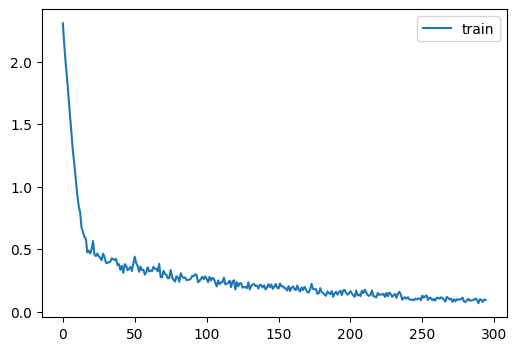

Fit 5 in: 41.92s, setup: 0.00s, 7.98 ± 0.02s per epoch, 0.03 ± 0.00s per batch


In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
## Lareger view point smaller batch

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLUb), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest')])

AttributeError: module 'torch.nn' has no attribute 'SiLUb'

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, pretrained=False), m=1, 
            leaky=0.0003, xtra=[upscale_cb(4, 'nearest')])

## Dropout

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.2, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.1, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.3, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.4, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.5, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.6, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)

In [ ]:
learn = run(timm.create_model('resnet18d', in_chans=1, num_classes=10, act_layer=nn.SiLU, drop_rate=0.7, pretrained=False), 
            leaky=0.0003, xtra=[upscale_cb(2, 'nearest')], m=4)